In [2]:
#Used to make data more uniform across screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

In [2]:
#This will setup my directories for all of the data files in the 100-bird-species dataset. 
BASE_DIR = 'dataset'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['test', 'train', 'valid']


In [3]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

250 CATEGORIES are  ['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CH

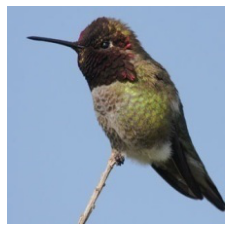

Figures are  (224, 224, 3)


In [4]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("dataset/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [5]:
#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, )

In [6]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
print(Train_groups)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 35215 images belonging to 250 classes.
data groups: 1101
1101
Found 1250 images belonging to 250 classes.
data groups: 40
validation image qty: 1250
Found 1250 images belonging to 250 classes.
data groups: 40


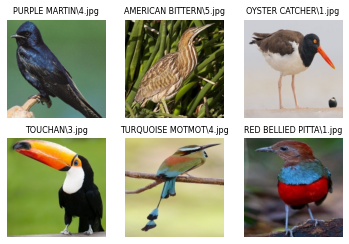

In [7]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

In [10]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(Category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, 
                                                  momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# ------------------------------------------------------------------------------------------------------

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from datetime import datetime

mc = ModelCheckpoint('best_model_projeto2.h5', monitor='val_loss', mode='min', save_best_only=True)

# ------------------------------------------------------------------------------------------------------

#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1),
               mc
    ]) 
                # left verbose 1 so I could see the learning rate decay

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               12544250  
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
Total params: 15,773,114
Trainable params: 12,544,250
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/50
1101/1101 [==============================] - 307s 278ms/step - loss: 4.2495 - accuracy: 0.5

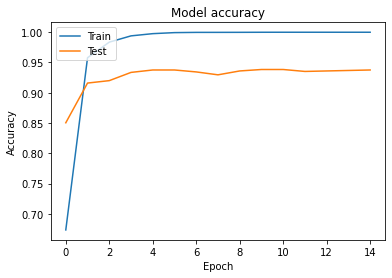

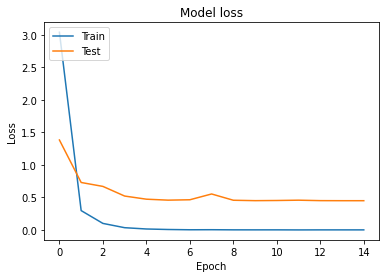

40/40 [==============================] - 10s 243ms/step - loss: 0.2751 - accuracy: 0.9584
Test loss: 0.27506011724472046
Test accuracy: 0.9584000110626221


In [11]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [12]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    print (probability, ' % chances are there that the Bird Is',icd[answer[0]])

61.48  % chances are there that the Bird Is AFRICAN FIREFINCH


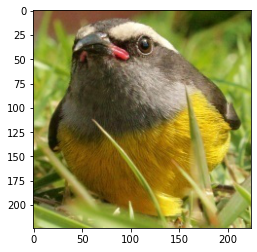

In [20]:
img="dataset/valid/BANANAQUIT/5.jpg"
pic=load_img(img,target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [14]:
np.save('my_history.npy',history.history)

In [11]:
history2=np.load('my_history.npy',allow_pickle='TRUE').item()

In [10]:
import h5py
from keras.models import load_model
model = load_model('best_model_projeto.h5')

In [17]:
dic=train_data.class_indices
icd={k:v for v,k in dic.items()}
def output2(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    probability=round(np.max(model.predict_proba(img)*100),2)
    return (probability,location)

In [18]:
import os

folder = "dataset/valid/"
paths = [os.path.join(root,filename) for root, directories, filenames in os.walk(folder) for filename in filenames]

a = []
counter = 0
for img in paths:
    pic=load_img(img,target_size=(224,224,3))
    a.append(output2(img))
    counter += 1
    if(counter % 50 == 0):
        print(f'{counter}/{len(paths)}')

50/1250
100/1250
150/1250
200/1250
250/1250
300/1250
350/1250
400/1250
450/1250
500/1250
550/1250
600/1250
650/1250
700/1250
750/1250
800/1250
850/1250
900/1250
950/1250
1000/1250
1050/1250
1100/1250
1150/1250
1200/1250
1250/1250


In [19]:
a_sorted = sorted(a)
print(a_sorted)

[(30.78, 'dataset/valid/BOBOLINK\\2.jpg'), (37.44, 'dataset/valid/GOLD WING WARBLER\\1.jpg'), (38.87, 'dataset/valid/MASKED LAPWING\\1.jpg'), (41.58, 'dataset/valid/SAND MARTIN\\5.jpg'), (43.53, 'dataset/valid/COMMON HOUSE MARTIN\\2.jpg'), (47.68, 'dataset/valid/YELLOW HEADED BLACKBIRD\\3.jpg'), (50.93, 'dataset/valid/CAPE MAY WARBLER\\2.jpg'), (51.2, 'dataset/valid/COMMON GRACKLE\\5.jpg'), (51.7, 'dataset/valid/RUFUOS MOTMOT\\1.jpg'), (52.09, 'dataset/valid/AMERICAN REDSTART\\2.jpg'), (55.52, 'dataset/valid/AFRICAN FIREFINCH\\4.jpg'), (56.13, 'dataset/valid/BLUE HERON\\5.jpg'), (57.99, 'dataset/valid/CRESTED AUKLET\\5.jpg'), (59.52, 'dataset/valid/OSPREY\\1.jpg'), (61.48, 'dataset/valid/BANANAQUIT\\5.jpg'), (61.79, 'dataset/valid/ELEGANT TROGON\\2.jpg'), (61.96, 'dataset/valid/OKINAWA RAIL\\4.jpg'), (63.94, 'dataset/valid/GILDED FLICKER\\4.jpg'), (66.85, 'dataset/valid/RING-NECKED PHEASANT\\4.jpg'), (67.2, 'dataset/valid/KING VULTURE\\3.jpg'), (70.16, 'dataset/valid/NORTHERN BALD IBIS

In [24]:
a = [i[0] for i in a_sorted if(i[0] == 100.0)]
print(len(a))

1054
